# Setup

In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html

INFO:dt-world:duckietown-world 1.0.30
INFO:zj:zj 2.0.4
INFO:dt-world:contracts 1.8.12 


ha


In [3]:
dw.logger.setLevel(50)

Better visualization of output

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

# Road Network
Let's load a map and compute the road network.

In [5]:
m = dw.load_map('ethz_amod_lab_k31')


Use the function `get_skeleton_graph`:

In [6]:
sk = dw.get_skeleton_graph(m)

The return type is `SkeletonGraphResult`. It contains in `sk.root2` a new map with the joined lane segments. 

In [20]:
ipython_draw_html(sk.root2);

While in the attribute `sk.G` we find a graph describing the topology.

This is a graph where each node is a meeting point between lanes, and each edge represents a lane.

In [8]:
# nodes
print(list(sk.G))

['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19']


In [9]:
# edges
for n1, n2 in sk.G.edges():
    data = sk.G.get_edge_data(n1, n2)
    one_lane = data[0]['lane']
    print('I can go from %s to %s using lane %s' % (n1, n2, one_lane))

I can go from P0 to P11 using lane L19
I can go from P1 to P5 using lane ls009
I can go from P1 to P3 using lane ls008
I can go from P2 to P0 using lane ls004
I can go from P2 to P3 using lane ls005
I can go from P3 to P6 using lane L10
I can go from P4 to P5 using lane ls007
I can go from P4 to P0 using lane ls006
I can go from P5 to P8 using lane L14
I can go from P6 to P14 using lane ls036
I can go from P6 to P13 using lane ls037
I can go from P6 to P10 using lane ls035
I can go from P7 to P4 using lane L11
I can go from P8 to P16 using lane ls052
I can go from P8 to P19 using lane ls053
I can go from P9 to P2 using lane L15
I can go from P10 to P1 using lane L18
I can go from P11 to P14 using lane ls040
I can go from P11 to P13 using lane ls038
I can go from P11 to P7 using lane ls039
I can go from P12 to P13 using lane ls033
I can go from P12 to P10 using lane ls034
I can go from P12 to P7 using lane ls032
I can go from P13 to P18 using lane L31
I can go from P14 to P17 using lane

Let's bring in the `draw_graph` function from some time ago.

In [10]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

Set the position of each node in the graph based on the attribute 'point'.

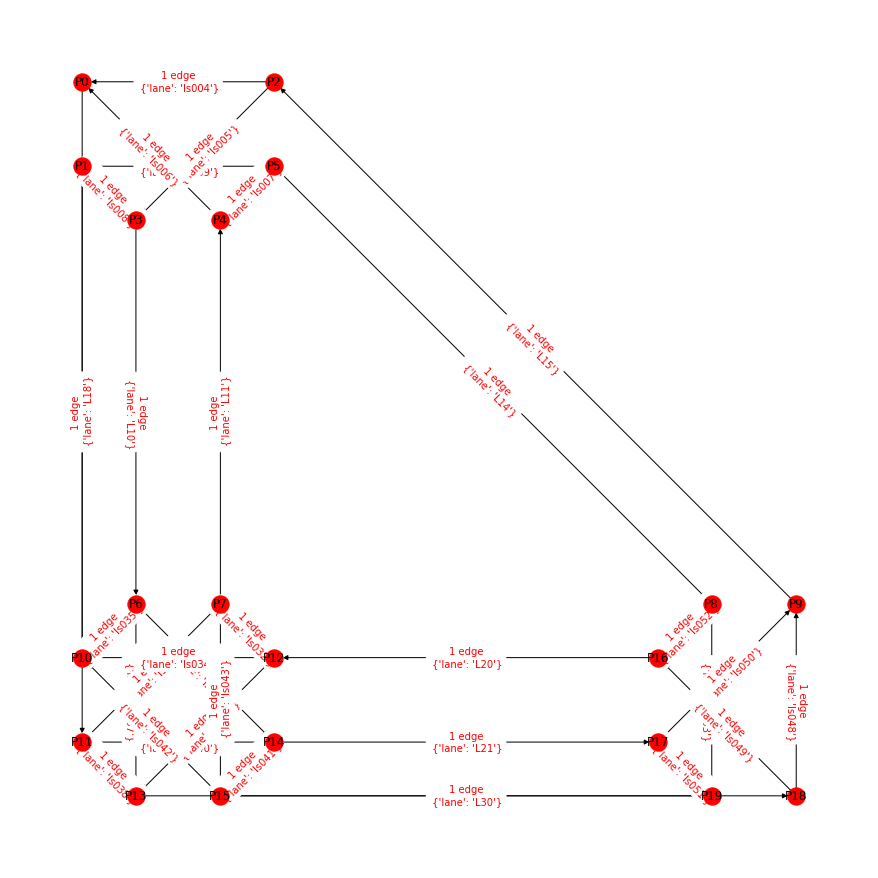

In [18]:
import geometry as geo
pos = {}
for n in sk.G:
    q = sk.G.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(sk.G, pos=pos)

## Planning example

Here is an example of how to do planning on the road network.

We select a start and end node:

In [12]:
start = 'P0'
end = 'P18'

We find the shortest path:

In [13]:
import networkx as nx
path = nx.shortest_path(sk.G, start, end)
print(path)

['P0', 'P11', 'P13', 'P18']


We retrieve the edge names:

In [14]:
def get_lanes(path):
    edges = zip(path[:-1], path[1:]) 
    lanes  = []
    for a, b in edges:
        lane = sk.G.get_edge_data(a, b)[0]['lane']
        lanes.append(lane)
    return lanes

In [15]:
lanes = get_lanes(path);
print(lanes)

['L19', 'ls038', 'L31']


For visualization, we create a new map containing only the lanes selected: 

In [16]:
po = dw.PlacedObject()
for lane_name in lanes:
    lane = sk.root2.children[lane_name]
    po.set_object(lane_name, lane, ground_truth=dw.SE2Transform.identity())

In [17]:
ipython_draw_html(po);